In [1]:
#pip install --upgrade threadpoolctl

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Anomaly Detection packages
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

In [15]:
# Load dataset
df = pd.read_csv("london_air_quality.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    4080 non-null   object
 1    pm25   4080 non-null   object
 2    pm10   4080 non-null   object
 3    o3     4080 non-null   object
 4    no2    4080 non-null   object
 5    so2    4080 non-null   object
 6    co     4080 non-null   object
dtypes: object(7)
memory usage: 223.2+ KB


In [22]:
# Interpolate missing values
df = df.replace(" ", float("NaN"))  # Convert empty strings to NaN

df2 = pd.DataFrame()

df2["date"] = pd.to_datetime(df["date"])

# df2["year"] = df2["date"].dt.year
df["month"] = df2["date"].dt.month
df["season"] = df["month"].apply(lambda x: "Winter" if x in [12, 1, 2] else
                                 "Spring" if x in [3, 4, 5] else
                                 "Summer" if x in [6, 7, 8] else "Fall")

df2["pm25"] = df[" pm25"].astype(float)
df2["pm10"] = df[" pm10"].astype(float)
df2["o3"] = df[" o3"].astype(float)
df2["no2"] = df[" no2"].astype(float)
df2["so2"] = df[" so2"].astype(float)
df2["co"] = df[" co"].astype(float)

df2.set_index('date', inplace=True)

#Sort the DataFrame by the index
df2.sort_index(inplace=True)

df2 = df2.interpolate(method='time')

pm25    1.711712
pm10    1.328275
o3      0.774352
no2     0.531077
so2     2.071911
co      1.016388
dtype: float64

In [4]:
df2

,year,month,pm25,pm10,o3,no2,so2,co
date,,,,,,,,
2014-01-01,2014,1,50.0,16.0,1.0,5.0,1.000,33.0
2014-01-02,2014,1,37.0,20.0,1.0,29.0,11.000,5.0
2014-01-03,2014,1,46.0,27.0,1.0,28.0,3.000,5.0
2014-01-04,2014,1,49.0,18.0,1.0,27.0,3.000,5.0
2014-01-05,2014,1,48.0,15.0,1.0,27.0,3.000,5.0
...,...,...,...,...,...,...,...,...
2025-03-05,2025,3,88.0,51.0,1.0,28.0,1.125,3.0
2025-03-06,2025,3,116.0,50.0,1.0,32.0,1.000,4.0
2025-03-07,2025,3,103.0,31.0,1.0,21.0,1.000,2.0


In [5]:
# Encode categorical variables
label_enc = LabelEncoder()
df2["Season Code"] = label_enc.fit_transform(df["season"])

In [6]:
# Select features for methods
features = ["pm25", "pm10", "o3", "no2", "so2", "co", "Season Code"]
data = df2[features]

# Isolation Forest

In [7]:
# Fit the Isolation Forest model
model = IsolationForest(contamination=0.015)  # Assume 2.5% of the data are anomalies
model.fit(data)

# Predict anomalies (-1 for anomaly, 1 for normal)
predictions = model.predict(data)
data["Iso_Anomaly"] = predictions
#print(data["Iso_Anomaly"])

# Anomalies will be marked as -1
normal = data[predictions == 1]
anomalies = data[predictions == -1]

# print("Anomalies detected using Isolation Forest:")
# print(anomalies)

Anomalies detected using Isolation Forest:
             pm25  pm10   o3   no2   so2    co  Season Code  Iso_Anomaly
date                                                                    
2014-03-14  151.0  69.0  1.0  58.0   7.0   4.0            1           -1
2014-04-03  144.0  61.0  1.0  31.0   2.0   4.0            1           -1
2014-09-22   53.0  35.0  1.0  35.0  20.0   6.0            0           -1
2014-09-23   92.0  42.0  1.0  25.0  14.0   6.0            0           -1
2014-11-29   86.0  44.0  1.0  29.0   5.0  12.0            0           -1
...           ...   ...  ...   ...   ...   ...          ...          ...
2022-03-25  144.0  64.0  1.0  37.0   3.0   3.0            1           -1
2022-11-13   54.0  25.0  1.0  17.0  26.0   3.0            0           -1
2022-12-11  107.0  40.0  1.0  28.0   3.0  19.0            3           -1
2023-01-23  115.0  53.0  1.0  42.0   3.0  13.0            3           -1
2025-01-12  129.0  43.0  1.0  31.0   2.0  12.0            3           -1

[62 row

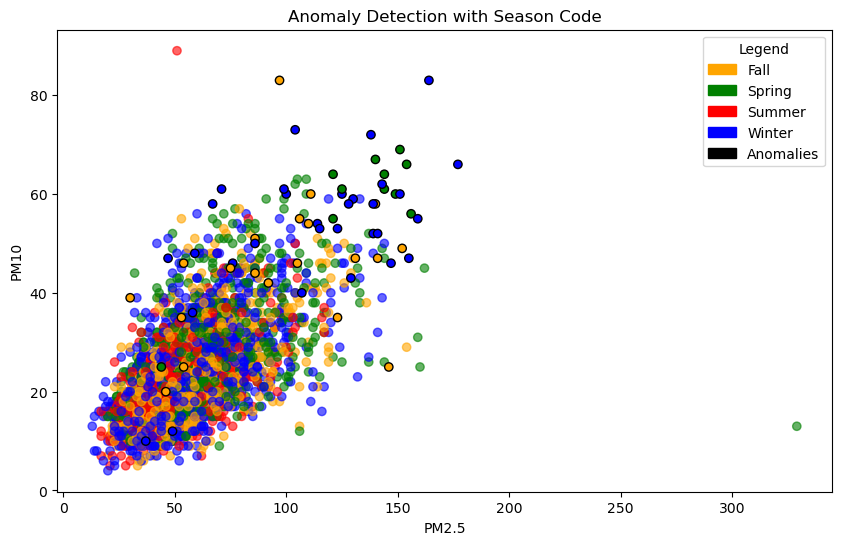

In [8]:
# Define season colors in the correct order (Fall, Spring, Summer, Winter)
season_colors = {0: 'orange', 1: 'green', 2: 'red', 3: 'blue'}

# Assign colors based on 'Season Code'
normal['color'] = normal['Season Code'].map(season_colors)
anomalies['color'] = anomalies['Season Code'].map(season_colors)  # Keep season color for anomalies too

# --- First Plot: Normal vs. Anomalies with Seasonal Colors ---
plt.figure(figsize=(10, 6))
plt.scatter(normal['pm25'], normal['pm10'], color=normal['color'], label='Normal', alpha=0.6)
plt.scatter(anomalies['pm25'], anomalies['pm10'], color=anomalies['color'], edgecolors='black', label='Anomalies', alpha=1)
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Anomaly Detection with Season Code')

# Custom legend for seasonal colors
legend_patches = [
    mpatches.Patch(color='orange', label='Fall'),
    mpatches.Patch(color='green', label='Spring'),
    mpatches.Patch(color='red', label='Summer'),
    mpatches.Patch(color='blue', label='Winter'),
    mpatches.Patch(color='black', label='Anomalies')  # Black edges indicate anomalies
]

plt.legend(handles=legend_patches, title="Legend", loc='upper right')
plt.show()

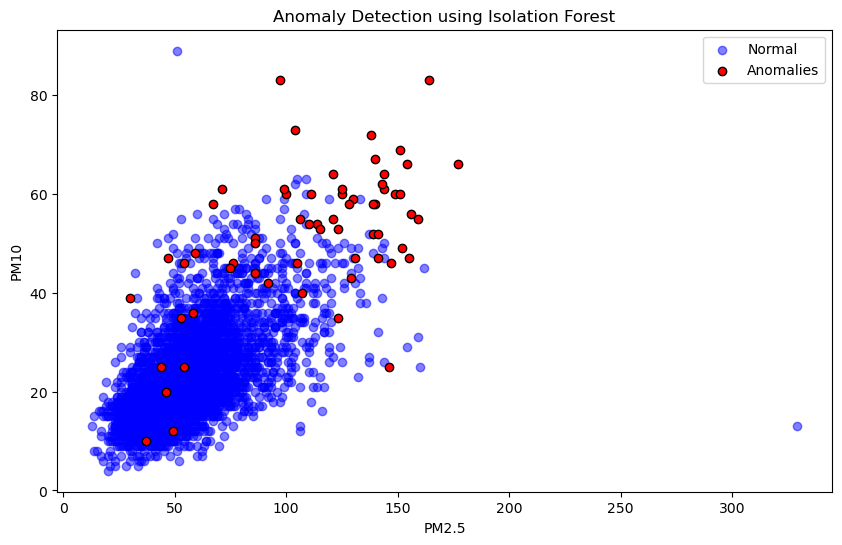

In [9]:
# --- Second Plot: Normal (Blue) vs. Anomalies (Red) ---
plt.figure(figsize=(10, 6))
plt.scatter(normal['pm25'], normal['pm10'], color='blue', label='Normal', alpha=0.5)
plt.scatter(anomalies['pm25'], anomalies['pm10'], color='red', edgecolors='black', label='Anomalies', alpha=1)
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()
plt.show()

# Z-Score 

In [10]:
# --- 2. Z-Score Method ---
z_scores = np.abs(zscore(data[["pm25", "pm10", "o3", "no2", "so2", "co"]]))
threshold = 5  # Define threshold for anomaly detection
data["Z_Anomaly"] = (z_scores > threshold).any(axis=1).astype(int)

# One-Class SVM

In [11]:
# --- 1. One-Class SVM ---
svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.00001)  # Lower nu for fewer anomalies
svm.fit(data)

# Predict anomalies
y_pred = svm.predict(data)
data["SVM_Anomaly"] = y_pred

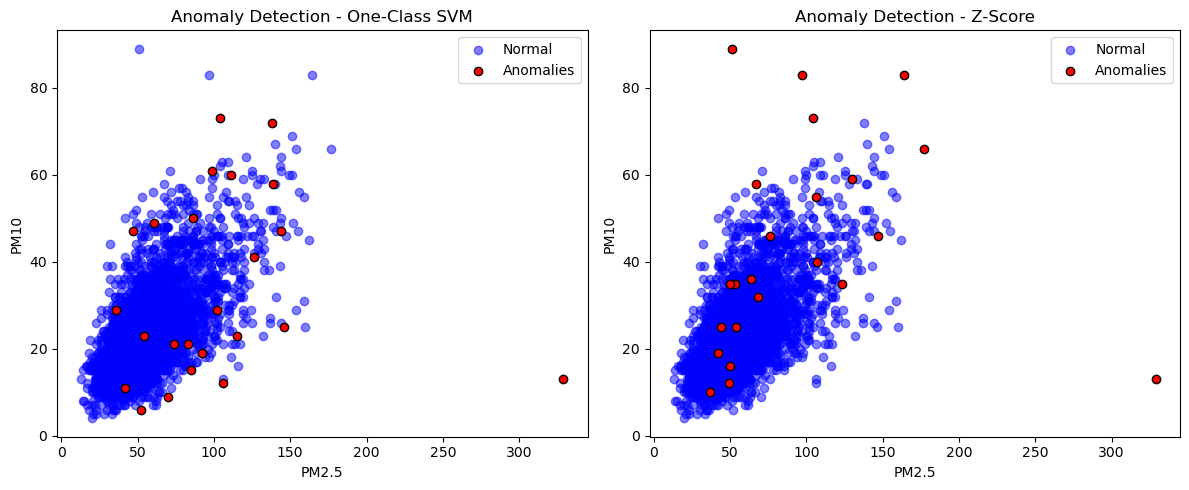

In [12]:
# --- Visualizing Anomalies ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

methods = ["SVM_Anomaly", "Z_Anomaly"]
titles = ["One-Class SVM", "Z-Score"]

for i, method in enumerate(methods):
    normal = data[data[method].isin([0, - 1])]
    anomalies = data[data[method] == 1]

    axes[i].scatter(normal["pm25"], normal["pm10"], color='blue', label="Normal", alpha=0.5)
    axes[i].scatter(anomalies["pm25"], anomalies["pm10"], color='red', edgecolors='black', label="Anomalies", alpha=1)
    axes[i].set_xlabel("PM2.5")
    axes[i].set_ylabel("PM10")
    axes[i].set_title(f"Anomaly Detection - {titles[i]}")
    axes[i].legend()

plt.tight_layout()
plt.show()

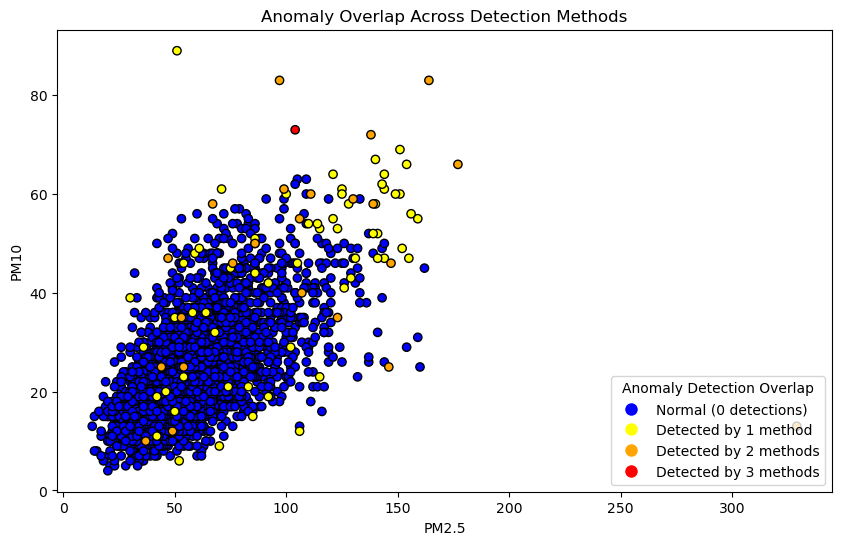

In [13]:
# Standardize anomaly labels (convert everything to 1 = anomaly, 0 = normal)
data["SVM_Anomaly"] = data["SVM_Anomaly"].map({-1: 0, 1: 1})  # SVM normal = -1, anomaly = 1
data["Z_Anomaly"] = data["Z_Anomaly"].map({0: 0, 1: 1})       # Z-Score normal = 0, anomaly = 1
data["Iso_Anomaly"] = data["Iso_Anomaly"].map({1: 0, -1: 1})  # Isolation Forest normal = 1, anomaly = -1

# Sum up anomaly counts (how many methods detected a point as an anomaly)
data["Anomaly_Score"] = data[["SVM_Anomaly", "Z_Anomaly", "Iso_Anomaly"]].sum(axis=1)

# Define colors based on anomaly score (more detections = stronger color)
color_map = {0: "blue", 1: "yellow", 2: "orange", 3: "red"}  # Adjust as needed
data["color"] = data["Anomaly_Score"].map(color_map)

data = data.sort_values(by="Anomaly_Score")

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Scatter plot with colors based on anomaly score
scatter = plt.scatter(data["pm25"], data["pm10"], c=data["color"], alpha=1, edgecolors="black", zorder=2)

# Manually add legend
legend_labels = {
    "blue": "Normal (0 detections)",
    "yellow": "Detected by 1 method",
    "orange": "Detected by 2 methods",
    "red": "Detected by 3 methods"
}
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for color, label in legend_labels.items()]
plt.legend(handles=legend_patches, title="Anomaly Detection Overlap", loc="lower right")

plt.xlabel("PM2.5")
plt.ylabel("PM10")
plt.title("Anomaly Overlap Across Detection Methods")
plt.show()

In [14]:
# Select points that are anomalies in all three methods
anomalies_all_three = data[data["Anomaly_Score"] == 3]

anomalies_all_three["season"] = anomalies_all_three["Season Code"].apply(lambda x: "Winter" if x in [3] else
                                 "Spring" if x in [1] else
                                 "Summer" if x in [2] else "Fall")

# Drop columns
columns_to_drop = ["Season Code", "Iso_Anomaly", "Z_Anomaly", "SVM_Anomaly", "Anomaly_Score", "color"]
anomalies_all_three = anomalies_all_three.drop(columns=columns_to_drop)

# Display the full DataFrame for these points
anomalies_all_three

,pm25,pm10,o3,no2,so2,co,season
date,,,,,,,
2017-01-22,104.0,73.0,1.0,63.0,8.0,13.0,Winter


1. London, United Kingdom
Ultra Low Emission Zone (ULEZ) Expansion (2023): In 2023, London expanded its ULEZ, aiming to reduce traffic emissions by charging older, more polluting vehicles a daily fee to enter certain areas. This expansion led to a 27% reduction in toxic gas emissions and significant improvements in nitrogen dioxide levels across the city. https://www.reuters.com/world/uk/london-air-quality-improves-after-expansion-levy-polluting-cars-says-report-2025-03-07/?utm_source=chatgpt.com

https://www.telegraph.co.uk/science/2017/01/24/air-pollution-london-passes-levels-beijingand-wood-burners-making/?msockid=3f77b9668edb670203f0ab4f8f73664d

1. PM2.5 (Particulate Matter ≤ 2.5 microns)
Sources:
Vehicle emissions: Diesel engines and gasoline-powered vehicles emit fine particles.
Burning of biomass: Stubble burning, forest fires, and household burning of wood, coal, or crop residues.
Industrial emissions: Factories and power plants releasing fine particulate matter.
Construction and road dust: Construction sites and unpaved roads contribute to fine dust particles.
Sea spray: Natural sea salt particles are a source of fine particulates, especially near coastal areas.
2. PM10 (Particulate Matter ≤ 10 microns)
Sources:
Vehicle emissions: Larger particles, particularly from older vehicles.
Construction dust: Excavation, demolition, and roadworks create larger particulate matter.
Agricultural activities: Dust from tilling and harvesting can contribute to PM10 levels.
Dust storms: In arid or semi-arid regions, dust storms can elevate PM10 levels.
Mining activities: Mining operations can generate large amounts of dust that contribute to PM10.
3. Ozone (O₃)
Sources:
Vehicular emissions: Nitrogen oxides (NOx) and volatile organic compounds (VOCs) from vehicles react in sunlight to form ozone.
Industrial emissions: Power plants and factories release NOx and VOCs, which contribute to ozone formation.
Agricultural activities: Fertilizer use and the release of VOCs from plants can contribute to ozone formation.
Wildfires: The combustion of vegetation releases VOCs and other precursors that can create ozone in the atmosphere.
Natural sources: Lightning and biological processes (like trees emitting VOCs) can contribute to ozone formation.
4. Nitrogen Dioxide (NO₂)
Sources:
Vehicle emissions: Diesel and gasoline engines release nitrogen oxides (NOx), including NO₂.
Industrial emissions: Power plants and chemical factories often emit NOx.
Agricultural activities: Use of fertilizers and animal waste can release nitrogen compounds into the atmosphere.
Fossil fuel combustion: Burning coal, oil, and gas for heating and power generation is a significant source of NO₂.
Wildfires: The combustion process releases nitrogen compounds, contributing to NO₂ levels.
5. Sulfur Dioxide (SO₂)
Sources:
Burning of coal and oil: Power plants and industrial facilities that burn fossil fuels are major sources of SO₂.
Volcanic eruptions: Volcanoes naturally emit sulfur compounds that can create SO₂.
Refining of petroleum: The petroleum refining process releases SO₂ as a byproduct.
Mining and smelting of metals: Extracting metals from ore (such as copper) releases sulfur compounds, leading to SO₂.
Biological sources: Certain bacteria in wetlands and oceans release sulfur compounds into the atmosphere.
6. Carbon Monoxide (CO)
Sources:
Vehicle emissions: Incomplete combustion of fuel in vehicles produces CO.
Residential heating: Burning wood, coal, or other solid fuels for heating can release CO indoors and outdoors.
Industrial processes: Factories and power plants that burn fossil fuels or engage in chemical production may emit CO.
Wildfires: Incomplete combustion of biomass (such as in forest fires) leads to CO emissions.
Agricultural burning: The burning of crops or other organic material in agricultural regions can produce CO.

# Links to data

#### Portland, OR

https://nam02.safelinks.protection.outlook.com/?url=https%3A%2F%2Faqicn.org%2Fhistorical%2F%23city%3Ausa%2Foregon%2Fportland&data=05%7C02%7CParker.Pratt%40oit.edu%7C62c46dad2b3148fb714608dd5cdb060c%7Cf4db50f235d14e0694e2167755273558%7C0%7C0%7C638768817949468461%7CUnknown%7CTWFpbGZsb3d8eyJFbXB0eU1hcGkiOnRydWUsIlYiOiIwLjAuMDAwMCIsIlAiOiJXaW4zMiIsIkFOIjoiTWFpbCIsIldUIjoyfQ%3D%3D%7C0%7C%7C%7C&sdata=40oQbt41wBYJfwP8IezYNFvNs8c%2BkfX%2BGlqWKQTYkwA%3D&reserved=0

#### Delhi, INDIA

https://nam02.safelinks.protection.outlook.com/?url=https%3A%2F%2Faqicn.org%2Fhistorical%2F%23city%3Adelhi%2Fmundka&data=05%7C02%7CParker.Pratt%40oit.edu%7C62c46dad2b3148fb714608dd5cdb060c%7Cf4db50f235d14e0694e2167755273558%7C0%7C0%7C638768817949481466%7CUnknown%7CTWFpbGZsb3d8eyJFbXB0eU1hcGkiOnRydWUsIlYiOiIwLjAuMDAwMCIsIlAiOiJXaW4zMiIsIkFOIjoiTWFpbCIsIldUIjoyfQ%3D%3D%7C0%7C%7C%7C&sdata=SkuqQLg34xl5eJrxu6VhEtecUHJPnU2ap%2Buu2AQ%2BLcg%3D&reserved=0

#### 2018 Pollution

https://www.reuters.com/graphics/INDIA-POLLUTION/01008173281/

#### May 2024

https://economictimes.indiatimes.com/news/india/delhis-pollution-worsens-this-may-is-already-more-polluted-than-the-previous-2-years/articleshow/110202588.cms